In [63]:
import pandas as pd
import numpy as np
import lightgbm as lgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [64]:
sample_df = pd.read_csv('sample_data.csv')
features = list(set(sample_df.columns) - set(("manual_fraud", "bot_fraud")))

In [84]:
X = sample_df[features]
y_manual = sample_df["manual_fraud"]
y_bot = sample_df["bot_fraud"]

X_train,X_test,y_train,y_test=train_test_split(X,y_manual,test_size=0.3,random_state=0)
d_train=lgb.Dataset(X_train.drop(columns=['visitor_profile']), label=y_train)

params={}
params['learning_rate']=0.03
params['boosting_type']='rf' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=5
#params["is_unbalance"]=True
params["bagging_freq"] = 5
params["bagging_fraction"] =0.5
#train the model 
clf=lgb.train(params,d_train,1) #train the model on 100 epocs
#prediction on the test set
X_test["y_pred"] = clf.predict(X_test.drop(columns=['visitor_profile']))
X_test["y_pred_binary"] = np.where(X_test["y_pred"] > 0.01, 1, 0)
X_test["y_test"] = y_test

# focus on manual cases
X_test = X_test[X_test["visitor_profile"].isin(("highly_suspicious_visitor", "suspicious_visitor", "manual_card_fraud", "normal_visitor"))]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1757, number of negative: 698243
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002510 -> initscore=-5.984959
[LightGBM] [Info] Start training from score -5.984959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/tillman/sentry/notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tillman/sentry/notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tillman/sentry/notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [85]:
tn, fp, fn, tp = confusion_matrix(X_test["y_test"], X_test["y_pred_binary"]).ravel()
sensitivity = tp / (tp+fn)
specificity = tn / (tn + fp)

## Accuracy
Accuracy is defined as correct predictions / total predictions

In [82]:
acc = accuracy_score(X_test["y_test"], X_test["y_pred_binary"])
print(f"accuracy: {acc}")

accuracy: 0.9966266664872937


## Sensitivity
Sensitivity (True Positive rate) measures the proportion of positives that are correctly identified (i.e. the proportion of those who have some condition (affected) who are correctly identified as having the condition).

In [86]:
sensitivity = tp / (tp+fn)
print("sensitivity: ", sensitivity)

sensitivity:  0.973421926910299


## Specificity
Specificity (True Negative rate) measures the proportion of negatives that are correctly identified (i.e. the proportion of those who do not have the condition (unaffected) who are correctly identified as not having the condition).

In [87]:
specificity = tn / (tn + fp)
print("specificity: ", specificity)

specificity:  0.9956469190084537


## ROC Curve
Receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

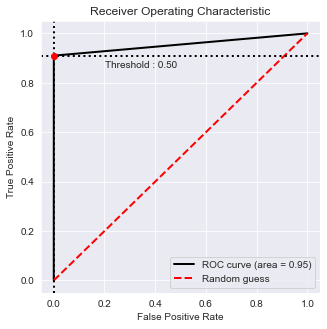

In [58]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1, random_state=23)
X_train,X_test,y_train,y_test=train_test_split(X,y_manual,test_size=0.3,random_state=0)
model = clf.fit(X_train.drop(columns=['visitor_profile']).fillna(True), y_train)

# Use predict_proba to predict probability of the class
y_pred = clf.predict_proba(X_test.drop(columns=['visitor_profile']).fillna(True))[:,1]

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Fraud", "Not Fraud"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

## Area Under Curve
AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions:

In [74]:
roc_auc_score(X_test["y_test"], X_test["y_pred"])

0.9975221609306393

## Log-loss
Log loss is the classification equivalent of Mean-Squared Error in the regression world. Like accuracy, it symmetrically penalizes all incorrect predictions. Log loss is a much more nuanced metric though, because it penalizes our predictions based on how confident they were. For example, if we predict a particular visitor is fraud with 99% probability, and it turns out they were legit, the penalty would be much higher than if we predicted fraud with 51% probability. 

Because we explicitly care about both confidence and accuracy, log-loss is actually a good metric for the world of fraud detection IMO. However, to make it truly useful, we need to incorporate a custom loss function so that False Positives and False Negatives are not treated eqaully. 

In [76]:

from sklearn.metrics import log_loss
log_loss(X_test["y_test"], X_test["y_pred"])

0.044192468639065466

## Metrics Summary
Important Metrics:
- AUC
- Sensitivity
- Log-loss (with custom loss function)

Unimportant Metrics:
- Accuracy
- Log-loss (without custom loss function)

## Unbalanced Data Approaches
- Weighted training - make it so errors for certain rows of data are penalized more heavily. In practice, we could correspond these weights to different visitor profiles (e.g. `manual_card_fraud` weighted much higher than `normal_visitor`)
- Balanced training - scale up the minority class so that both are represented equally in training data
- Generate fake data - lots of clever algos out there to simulate data corresponding to the smaller class - more sophisticated than Balanced training
- Custom loss function - calibrate the loss function to the real-world impact of a mistake. For example, if the cost is 100 for a False Negative (failed to detect fraud) and 1 for a False Positive (annoyed a legit guest), we could use a custom cost function of (100, 1) for relative cost of FN and FP


In [89]:
# 1) API classifies as fraud, drop off -> ?
# 2) API doesnt classify as fraud, chargeback -> FN
# 3) API classifies as fraud, dont drop off
# 4) API classifies as fraud, dont drop off, rejected anyway